<a href="https://colab.research.google.com/github/skolix15/Machine_Learning_2025/blob/main/Exercise_six_(6).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [20]:
import sys
!{sys.executable} -m pip install -U ydata-profiling[notebook]
!pip install jupyter-contrib-nbextensions
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [21]:
import pandas as pd
from ydata_profiling import ProfileReport

# Question 1

In [22]:
# Load Data
df = pd.read_csv("bankloan.csv")
# Create profile report object
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# # Appear to notebook
# profile.to_notebook_iframe()
# Save to HTML file
profile.to_file("notebook_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 53/53 [00:14<00:00,  3.78it/s]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Question 2

## Subquestion 1

Mean: 15116.256  

Max: 35000

Min: 1000

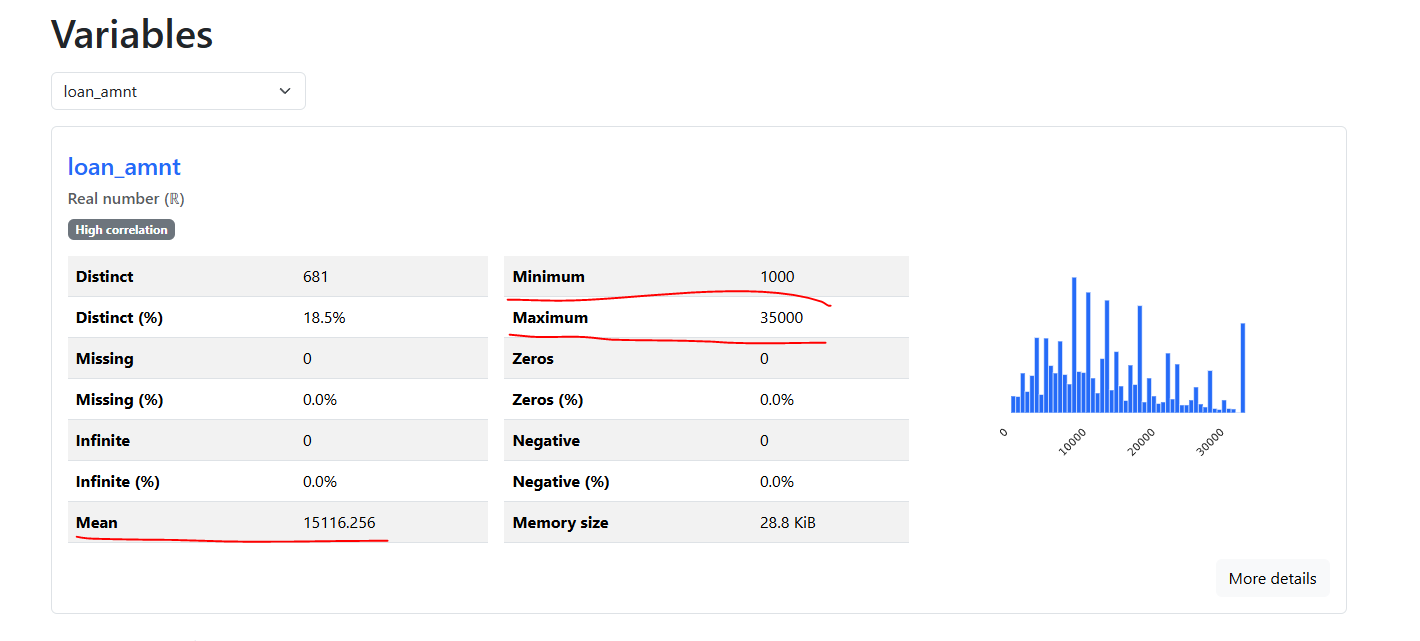

## Subquestion 2

Μπορούμε να αφαιρέσουμε τις παρακάτω μεταβλητές:

(a) Μεταβλητές που λειτουργούν ως αναγνωριστικά =>
    1. id (μοναδικές τιμές),
    2. mebmer_id (μοναδικές τιμές),
    3. row_id (μοναδικές τιμές),
    4. unnamed (είναι μη υποστηριζόμενου τύπου και έχει 100% ελλειπούσες τιμές)

(b) Μεταβλητές με μεγάλο ποσοστό ελλειπούσων τιμώ =>
    5. annual_inc_joint (99.9% ελλειπούσες τιμές)
    6. dti_joint (99.9% ελλειπούσες τιμές)
    7. 36months (86.1% ελλειπούσες τιμές, είναι υψηλά συσχετισμένη με τις μεταβλητές 60months & term)
    8. 60months (86.1% ελλειπούσες τιμές, είναι υψηλά συσχετισμένη με τις μεταβλητές 36months & term)
    9. next_pymnt_d (75.5% ελλειπούσες τιμές και μη ισρροπημένο -> 98.8%)
    10. mths_since_last_major_derog (71.8% ελλειπούσες τιμές)

(c) Μεταβλητές με υψηλή συσχέτιση =>
    11. title (υψηλά συσχετισμένη με τη μεταβλητή purpose, μπορεί να αφαιρεθεί διατηρώντας την purpose)
    12. grade & sub_grade (υψηλά συσχετισμένες μεταξύ τους. Ενδεχομένως, να αρκούσε η μία από τις δύο)
    13. funded_amnt & loan_amnt (υψηλά συσχετισμένες μεταξύ τους. Ενδεχομένως, να αρκούσε η μία από τις δύο)

In [23]:
# Set variable to drop
variables_to_drop = [

  # Identifiers/Non-predictive features
  'id', 'member_id', 'Row ID', 'Unnamed: 50',

  # Variables with high percentage of missing values (>70%)
  'annual_inc_joint', 'dti_joint', '36months', '60months',
  'next_pymnt_d', 'mths_since_last_major_derog', # ~71.8% missing

  # Redundant/Highly correlated variables
  'title', 'grade', 'funded_amnt'

]

# Drop the specified columns from the DataFrame
df_cleaned = df.drop(columns=variables_to_drop, axis=1)

# Print information
print(f"\nVariables dropped: {variables_to_drop}")
print(f"Cleaned DataFrame dimensions: {df_cleaned.shape}")


Variables dropped: ['id', 'member_id', 'Row ID', 'Unnamed: 50', 'annual_inc_joint', 'dti_joint', '36months', '60months', 'next_pymnt_d', 'mths_since_last_major_derog', 'title', 'grade', 'funded_amnt']
Cleaned DataFrame dimensions: (212999, 40)


## Subquestion 3

In [24]:
# Fill undefined/null values

# Get numerical columns
numerical_columns = df_cleaned.select_dtypes(include=['number']).columns

# Get categorical columns
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns

# Fill empty numerical columns with mean value
for column in numerical_columns:
  if df_cleaned[column].isnull().any():
          mean_value = df_cleaned[column].mean()
          df_cleaned[column].fillna(mean_value)

# Fill empty categorical columns with most used value (mode)
for column in categorical_columns:
    if df_cleaned[column].isnull().any():
        # Using .iloc[0] in order to get the first value, in case of multiple modes
        mode_value = df_cleaned[column].mode().iloc[0]
        df_cleaned[column].fillna(mode_value)

# Store updated/cleaned dataframe in new csv file
df_cleaned.to_csv("bankloan_cleaned.csv", index=False)
print("Updated/cleaned Dataframe was stored in 'bankloan_cleaned.csv' file!")

Updated/cleaned Dataframe was stored in 'bankloan_cleaned.csv' file!


## Subquestion 4

In [25]:
# Set target values/subgrades
target_sub_grades = ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2']

# Create target column with values 0 and 1
# Target: 1 => if sub_grade is in target_sub_grades
# Target: 0 =>  otherwise
df['target_loan_risk'] = df['sub_grade'].apply(lambda x: 1 if x in target_sub_grades else 0)

# Calculate target counts & perchentages
target_counts = df['target_loan_risk'].value_counts()
target_percentages = (df['target_loan_risk'].value_counts(normalize=True) * 100).round(2).astype(str) + ' %'

# Print results
print(f"Target Counts:\n{target_counts.to_string(header=False)}\n")
print(f"Target Percentages:\n{target_percentages.to_string(header=False)}\n")

Target Counts:
0    151709
1     61290

Target Percentages:
0    71.23 %
1    28.77 %



Με βάση τα παραπάνω στατιστικά, παρατηρούμε ότι η μεταβλητή target παρουσιάζει σημαντική ανισορροπία. Η κλάση 0 (Υψηλότερος Κίνδυνος/Non-Target) κυριαρχεί με $71.32\%$, ενώ η κλάση 1 (Χαμηλός Κίνδυνος/Target) αποτελεί τη μειοψηφία ($28.68\%$).

## Subquestion 5

# Question 3

# Question 4

# Question 5